In [1]:
import pandas as pd
import numpy as np

# User Embedding

## Load Users' Data

In [2]:
n=3000000
ratings_df = pd.read_table("ml-10M100K/r1.train", sep="::", names=["userId", "movieId", "rating", "timestamp"], nrows=n)

<ipython-input-2-7935abd94ba0>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_table("ml-10M100K/r1.train", sep="::", names=["userId", "movieId", "rating", "timestamp"], nrows=n)


In [3]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,14575,173,4.0,828302493
1,14575,188,4.0,828302494
2,14575,196,4.0,828302494
3,14575,208,4.0,828302494
4,14575,216,4.0,828302493


In [4]:
ratings_df.shape

(3000000, 4)

In [5]:
ratings_df.drop("timestamp", axis=1, inplace=True)
ratings_df.head()


,userId,movieId,rating
0,14575,173,4.0
1,14575,188,4.0
2,14575,196,4.0
3,14575,208,4.0
4,14575,216,4.0


In [6]:
ratings_df.head()


,userId,movieId,rating
0,14575,173,4.0
1,14575,188,4.0
2,14575,196,4.0
3,14575,208,4.0
4,14575,216,4.0


In [7]:
users=[k for k,v in ratings_df['userId'].value_counts().iteritems() if v>2]
movies=[k for k,v in ratings_df['movieId'].value_counts().iteritems() if v>10]
ratings_df=ratings_df[(ratings_df['userId'].isin(users)) & (ratings_df['movieId'].isin(movies))]
ratings_df=ratings_df.pivot(index='userId',columns='movieId',values='rating').astype('float32')
ratings_df.reset_index(drop=True,inplace=True)
ratings_df.fillna(0.0, inplace=True)
print ('Dataframe size: {}'.format(ratings_df.shape))

Dataframe size: (20685, 8023)


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_df, test_df = train_test_split(ratings_df, test_size=0.1, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.09)
del ratings_df

In [10]:
train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
print ('Train dataframe size: {}'.format(train_df.shape))
print ('Valid dataframe size: {}'.format(valid_df.shape))
print ('Test dataframe size: {}'.format(test_df.shape))

Train dataframe size: (16940, 8023)
Valid dataframe size: (1676, 8023)
Test dataframe size: (2069, 8023)


In [11]:
# from sklearn.preprocessing import Normalizer

In [12]:
# normalizer = Normalizer()
# train_df = normalizer.fit_transform(train_df)
# test_df = normalizer.transform(test_df)
# valid_df = normalizer.transform(valid_df)

In [13]:
import time
import os
def get_board_path(name: str = ""):
    return os.path.join(".", "tensorboard", time.strftime("%Y-%m-%d_%H:%M:%S", time.gmtime())+"_"+ name)

def get_checkpoint_path(name: str = ""):
    return os.path.join(".", "checkpoints", time.strftime("%Y-%m-%d_%H:%M:%S", time.gmtime())+"_"+ name)


In [14]:
import tensorflow as tf
from tensorflow import keras
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [15]:
import models

In [16]:
layers = [512, 256, 512]
activation = "selu"
output_activation = "selu"

In [17]:
ae_model = models.deep_auto_recommender_model(train_df, units=layers, activation_fn=activation, output_activation=output_activation, batch_normalization=False, latent_dropout=0.7, input_drop_out=0.1)
ae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=models.masked_mse, metrics=models.masked_rmse_clip)
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 8023)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 8023)              0         
_________________________________________________________________
encoder_1 (Dense)            (None, 512)               4108288   
_________________________________________________________________
tf.nn.selu (TFOpLambda)      (None, 512)               0         
_________________________________________________________________
latent (Dense)               (None, 256)               131328    
_________________________________________________________________
tf.nn.selu_1 (TFOpLambda)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

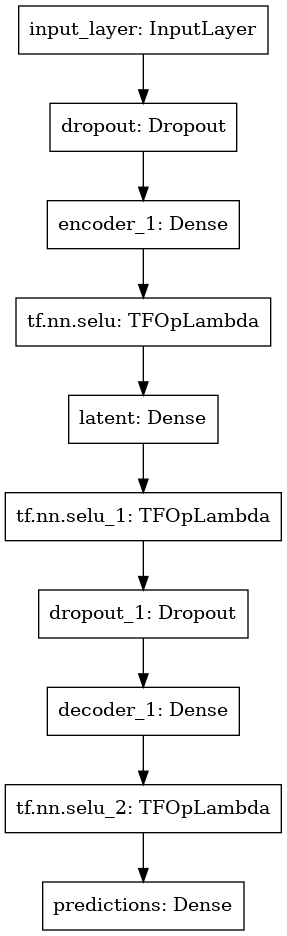

In [18]:
keras.utils.plot_model(ae_model, to_file="ratings_auto_encoder_model.png")

In [19]:
tb_cb = keras.callbacks.TensorBoard(get_board_path("ml10_users_ae"))
plateau_cb =keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=4)
checkpoints_cb = keras.callbacks.ModelCheckpoint(filepath=get_checkpoint_path("ml10_users_ae"), save_best_only=True)
early_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=1e-4)
callbacks = [tb_cb, plateau_cb, checkpoints_cb, early_cb]

In [20]:
hist_ae = ae_model.fit(x=train_df, y=train_df,
                  epochs=250,
                  batch_size=32,
                  validation_data=(valid_df, valid_df),
                  callbacks=callbacks)

Epoch 1/250
530/530 [==============================] - 13s 24ms/step - loss: 7.6040 - masked_rmse_clip: 1.7707 - val_loss: 2.6937 - val_masked_rmse_clip: 0.9601
INFO:tensorflow:Assets written to: ./checkpoints/2021-05-10_22:08:02_ml10_users_ae/assets
Epoch 2/250
530/530 [==============================] - 12s 23ms/step - loss: 2.7783 - masked_rmse_clip: 1.0489 - val_loss: 2.2712 - val_masked_rmse_clip: 0.9417
INFO:tensorflow:Assets written to: ./checkpoints/2021-05-10_22:08:02_ml10_users_ae/assets
Epoch 3/250
530/530 [==============================] - 12s 23ms/step - loss: 2.3052 - masked_rmse_clip: 0.9961 - val_loss: 1.9721 - val_masked_rmse_clip: 0.9298
INFO:tensorflow:Assets written to: ./checkpoints/2021-05-10_22:08:02_ml10_users_ae/assets
Epoch 4/250
530/530 [==============================] - 12s 23ms/step - loss: 1.9845 - masked_rmse_clip: 0.9667 - val_loss: 1.7467 - val_masked_rmse_clip: 0.9222
INFO:tensorflow:Assets written to: ./checkpoints/2021-05-10_22:08:02_ml10_users_ae/ass

530/530 [==============================] - 12s 23ms/step - loss: 0.9495 - masked_rmse_clip: 0.8745 - val_loss: 0.9951 - val_masked_rmse_clip: 0.8958
Epoch 36/250
530/530 [==============================] - 12s 23ms/step - loss: 0.9509 - masked_rmse_clip: 0.8752 - val_loss: 0.9924 - val_masked_rmse_clip: 0.8946
INFO:tensorflow:Assets written to: ./checkpoints/2021-05-10_22:08:02_ml10_users_ae/assets
Epoch 37/250
530/530 [==============================] - 12s 23ms/step - loss: 0.9544 - masked_rmse_clip: 0.8778 - val_loss: 0.9950 - val_masked_rmse_clip: 0.8961
Epoch 38/250
530/530 [==============================] - 12s 23ms/step - loss: 0.9452 - masked_rmse_clip: 0.8728 - val_loss: 0.9962 - val_masked_rmse_clip: 0.8968
Epoch 39/250
530/530 [==============================] - 12s 23ms/step - loss: 0.9495 - masked_rmse_clip: 0.8753 - val_loss: 0.9987 - val_masked_rmse_clip: 0.8975
Epoch 40/250
530/530 [==============================] - 12s 23ms/step - loss: 0.9478 - masked_rmse_clip: 0.8743 -

In [29]:
import matplotlib.pyplot as plt

In [49]:
def show_rmse(history, skip, filename):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title(filename) #'model train vs validation masked_rmse'
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.savefig(filename + '.jpg',bbox_inches='tight', dpi=500)
    plt.show()

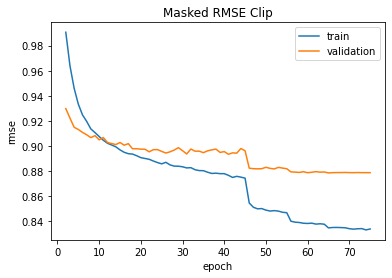

In [50]:
show_rmse(hist_ae,2, "Masked RMSE Clip")

In [51]:
def show_error(history, skip, filename):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title(filename) #'model train vs validation loss'
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.savefig(filename + '.jpg',bbox_inches='tight', dpi=500)
    plt.show()

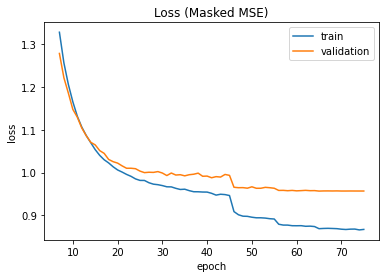

In [52]:
show_error(hist_ae, 7, "Loss (Masked MSE)")

In [55]:
ae_model.evaluate(test_df, test_df)

65/65 [==============================] - 0s 7ms/step - loss: 0.9974 - masked_rmse_clip: 0.8973


[0.9974052906036377, 0.8972718119621277]

In [57]:
ae_model.save("movielens10_users_embedding/auto_encoder")

INFO:tensorflow:Assets written to: movielens10_users_embedding/auto_encoder/assets


In [58]:
train_df.to_pickle("movielens10_users_embedding/ratings_train.pkl")
test_df.to_pickle("movielens10_users_embedding/ratings_test.pkl")
valid_df.to_pickle("movielens10_users_embedding/ratings_valid.pkl")

In [61]:
hist_df = pd.DataFrame(hist_ae.history)

In [62]:
hist_df.head()

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip,lr
0,4.654122,1.346634,2.693665,0.960090,0.0001
1,2.652906,1.036692,2.271235,0.941658,0.0001
2,2.225026,0.990700,1.972055,0.929821,0.0001
3,1.927146,0.963956,1.746704,0.922194,0.0001
4,1.706898,0.946020,1.572085,0.914894,0.0001


In [63]:
hist_df.to_pickle("movielens10_users_embedding/ae_history.pkl")